In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from astropy.io import fits
from sklearn.tree import DecisionTreeRegressor
import glob
from astropy import units as u
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Glob away all the fits in a dir
fits_list =glob.glob("sdss_fits_files/*.fits")
print(fits_list)

#Extra the fits tables from all the globbed fits
specdata_list=[]
for i in fits_list:
    with fits.open(i) as fit_file:
        specdata=fit_file[1].data
        header=fit_file[0].header
        specdata_list.append(specdata)


#Get the shapes of each spectra then find the smallest shape along 0 axis
spec_shape_list=[]
for i in specdata_list:
    print(i.shape)
    spec_shape_list.append(i.shape)

spec_shape_list=np.array(spec_shape_list)
smallest_spec=np.min(spec_shape_list)

'''
#Performing filtering of the spectra along lambda axis as data is not recording properly from first lambda
#to last lambda, as in some spectra the measurements start from different first to different last lambda
spectra_filtered_list=[]
for i in specdata_list:
    spec=i
    #apply booleam mask along lambda axis from 3.562 to 3.957 lambdas
    mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
    filtered_data = spec[mask]
    spectra_filtered_list.append(filtered_data)
#And here we have a np array containing individual spectras
spectra_filtered_list=np.array(spectra_filtered_list)
spectra_filtered_list.shape


# Use the row index (fiber index) as the feature, and the spectra as the target
spectra_filtered_list_array=np.array(spectra_filtered_list['sky'])
indi
ces= np.arange(spectra_filtered_list_array.shape[0]).reshape(-1,1)
#x_train, x_test=train_test_split(spectra_filtered_list_array, test_size=0.1, random_state=42)
'''

['sdss_fits_files/spec-1944-53385-0536.fits', 'sdss_fits_files/spec-2341-53738-0567.fits', 'sdss_fits_files/spec-2297-53738-0160.fits', 'sdss_fits_files/spec-2297-53738-0221.fits', 'sdss_fits_files/spec-1947-53431-0343.fits', 'sdss_fits_files/spec-1947-53431-0275.fits', 'sdss_fits_files/spec-1950-53436-0244.fits', 'sdss_fits_files/spec-2342-53742-0406.fits', 'sdss_fits_files/spec-2342-53742-0148.fits', 'sdss_fits_files/spec-2296-53735-0441.fits', 'sdss_fits_files/spec-2344-53740-0238.fits', 'sdss_fits_files/spec-1950-53436-0200.fits', 'sdss_fits_files/spec-2342-53742-0491.fits', 'sdss_fits_files/spec-2342-53742-0337.fits', 'sdss_fits_files/spec-1947-53431-0034.fits', 'sdss_fits_files/spec-2297-53738-0516.fits', 'sdss_fits_files/spec-2297-53738-0617.fits', 'sdss_fits_files/spec-1947-53431-0020.fits', 'sdss_fits_files/spec-1947-53431-0181.fits', 'sdss_fits_files/spec-1947-53431-0072.fits', 'sdss_fits_files/spec-1947-53431-0624.fits', 'sdss_fits_files/spec-2342-53742-0511.fits', 'sdss_fit

"\n#Performing filtering of the spectra along lambda axis as data is not recording properly from first lambda\n#to last lambda, as in some spectra the measurements start from different first to different last lambda\nspectra_filtered_list=[]\nfor i in specdata_list:\n    spec=i\n    #apply booleam mask along lambda axis from 3.562 to 3.957 lambdas\n    mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)\n    filtered_data = spec[mask]\n    spectra_filtered_list.append(filtered_data)\n#And here we have a np array containing individual spectras\nspectra_filtered_list=np.array(spectra_filtered_list)\nspectra_filtered_list.shape\n\n\n# Use the row index (fiber index) as the feature, and the spectra as the target\nspectra_filtered_list_array=np.array(spectra_filtered_list['sky'])\nindi\nces= np.arange(spectra_filtered_list_array.shape[0]).reshape(-1,1)\n#x_train, x_test=train_test_split(spectra_filtered_list_array, test_size=0.1, random_state=42)\n"

In [3]:
#Filtering routine

# Finding a target lenght for filtering
target_length = sum((3.582 <= lam <= 3.957) for lam in specdata_list[0].loglam)

spectra_filtered_list = []
for i in specdata_list:
    spec = i
    # Apply boolean mask along lambda axis from 3.582 to 3.957
    mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
    filtered_data = spec[mask]
    
    # Adjust the length to match target_length
    if len(filtered_data) < target_length:
        # If shorter, pad with NaNs or another value of choice and relpace missing vals with mean of the spectrum
        filtered_data = np.pad(filtered_data, (0, target_length - len(filtered_data)), constant_values=np.mean(filtered_data['sky'])) 
    elif len(filtered_data) > target_length:
        # If longer, truncate
        filtered_data = filtered_data[:target_length]
        
    spectra_filtered_list.append(filtered_data)

# Convert to numpy array now that all arrays are the same length
spectra_filtered_list = np.array(spectra_filtered_list)
spectra_filtered_list.shape

# Extract 'sky' values from each spectrum if they exist
if 'sky' in spectra_filtered_list.dtype.names:
    spectra_filtered_list_array = spectra_filtered_list['sky']


In [9]:
indices= np.arange(spectra_filtered_list_array.shape[0]).reshape(-1,1)

ml_regression_methods=[DecisionTreeRegressor(),RandomForestRegressor(), LinearRegression()]
master_sky_spectrum_list=[]
for reg_method in ml_regression_methods:
    ml_reg=reg_method
    ml_reg.fit(indices, spectra_filtered_list_array)

    #Generate the master sky from prediction
    master_sky=ml_reg.predict( np.array(0).reshape(-1,1))
    master_sky_spectrum_list.append(master_sky)

In [19]:
#scaling the master sky to the science spectra
ref_master= master_sky_spectrum_list[0][:,3600:3750]
ref_sky=spectra_filtered_list['sky'][0,3600:3750]
scaling=np.mean(ref_sky/ref_master)

scaled_master_sky_spectrum_list=[]
for i in master_sky_spectrum_list:
    master_scaled=i*scaling
    scaled_master_sky_spectrum_list.append(master_scaled)


Text(0, 0.5, 'Flux')

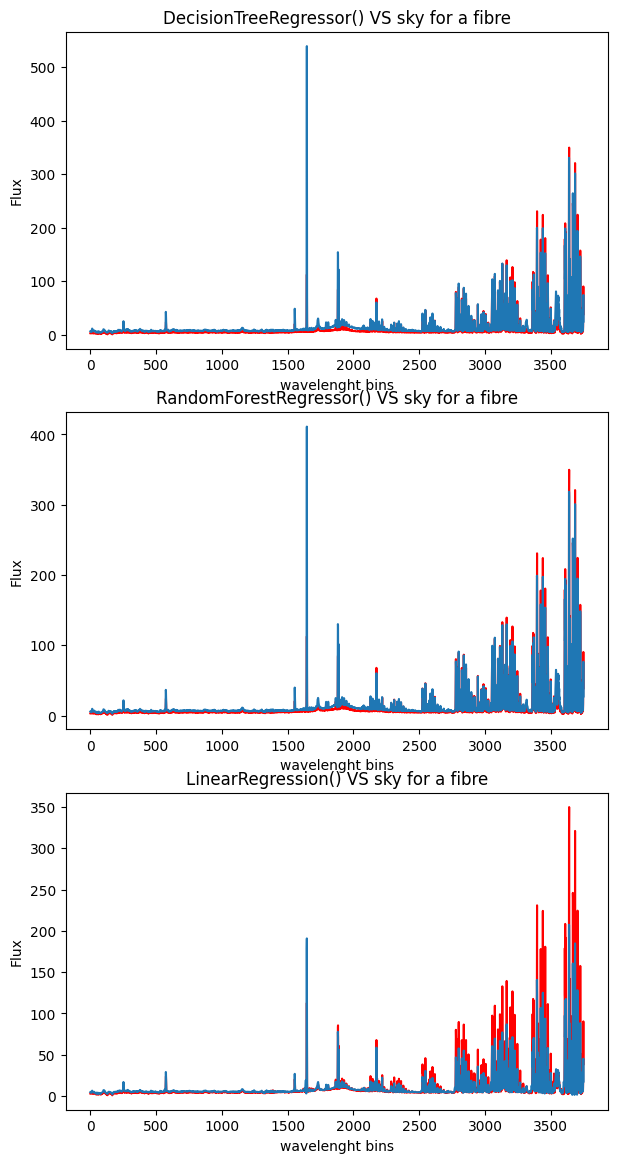

In [25]:
#scaling plots comparison

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,14))

spectra_no=41
ax[0].plot(spectra_filtered_list_array[spectra_no], c='r')
ax[0].plot(scaled_master_sky_spectrum_list[0][0])
ax[0].set_title( f"{ml_regression_methods[0]} VS sky for a fibre")
ax[0].set_xlabel('wavelenght bins')
ax[0].set_ylabel('Flux')

ax[1].plot(spectra_filtered_list_array[spectra_no], c='r')
ax[1].plot(scaled_master_sky_spectrum_list[1][0])
ax[1].set_title( f"{ml_regression_methods[1]} VS sky for a fibre")
ax[1].set_xlabel('wavelenght bins')
ax[1].set_ylabel('Flux')

ax[2].plot(spectra_filtered_list_array[spectra_no], c='r')
ax[2].plot(scaled_master_sky_spectrum_list[2][0])
ax[2].set_title( f"{ml_regression_methods[2]} VS sky for a fibre")
ax[2].set_xlabel('wavelenght bins')
ax[2].set_ylabel('Flux')




